In [8]:
import math
from typing import Any

import torch

from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch import functional as F

from torch.nn import Module
from scipy.stats import pareto 
from torch.distributions.pareto import Pareto
from torch.nn import init
seed=0
#torch.cuda.manual_seed_all(seed)

#emptying any left over file from previous run
with torch.cuda.device('cuda:0'):
    torch.cuda.empty_cache()

import datetime
import os

import torch
import torchvision
#torch.cuda.is_available()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
#from torch.autograd.functional import jacobian
#import torch.autograd.functional
import time
import copy
import matplotlib.pyplot as plt
import pandas as pd
    

In [9]:
def add_gaussian_noise(inputs,strength):
    #add guassian noise to input image

    #print(inputs.size())
    noise = torch.randn_like(inputs)*strength*torch.max(inputs)
    result=inputs + noise
    return result


def add_powerlaw_noise(input_size,batch_size,strength,images):
    ##add power law noise(not use for not )

    ##input size here is the side of the image 28 
    m = Pareto(torch.tensor([1.0]), torch.tensor([1.0]))
    res=m.sample(images.size())

    temp=res/np.sqrt(res.var())/N/batch_size*strength
    noise=temp-temp.mean()
    #if print_bool:
     #   plt.title(powerlaw_noise print)
      #  plt.hist(noise.flatten(),density=True, bins='auto', histtype='stepfilled')
        
      #  plt.show()
    #print(noise[:,:,:,:,0].size())
    return noise[:,:,0]+images

def validation(test_loader):
    #checking the accuracy of prediction on the test dataset
    with torch.no_grad():

     #valid_loss = criterion(outputs, batch_features.view(batch_size,-1).to(device))
        loss=0
        for batch_features, _ in test_loader:
            #input=add_noise(batch_features,).view(100, -1).to(device)
            input_image=add_gaussian_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
            #batch_feature = batch_features.view(batch_size, -1)
            #input_image =add_powerlaw_noise(input_size,batch_size,noise_strength,batch_feature).view(batch_size, -1).to(device)
            batch_feature = batch_features.view(batch_size, -1).to(device)
            outputs = model(input_image)
            valid_loss = criterion(outputs, input_image.to(device)) 
            #accuracy+=kl_div(outputs,batch_features)/batch_size
            loss += valid_loss.item()
    return loss/len(test_loader)
            
def kl_div(output_image,input_image):
    #one way to check how accurate
    accuracy=0
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    for i in range(len(input_image)):
        input_spectrum=torch.histogram(input_image[i].cpu(), bins=256, density=True)
        output_spectrum=torch.histogram(output_image[i].cpu(), bins=256, density=True)
        accuracy+=kl_loss(input_spectrum[i],output_spectrum[i])
    return accuracy/len(input_image)

def iteration(model,initial_inputs,no_of_repetition,epoch):
    y_pred=initial_inputs.to(device)
    for i in range(no_of_repetition):
        x_train=y_pred
        #if i==0:
           # name="progress asymptotic iteration:"+str(i)+" "
           # visualisation(x_train[0].cpu().detach(),epoch,name,False)
        #if i%5==1:
            #name="progress asymptotic iteration:"+str(i)+" "
            #visualisation(x_train[0].cpu().detach(),epoch,name,False)
        y_pred=model.internals(x_train)
    return x_train,y_pred,model 

def asymptotic_jacobian(model,initial_input,no_of_images,no_of_repetition):
    ave_jac=0
    overall_distribution=np.asarray([])

    jacobian=[]
    sorteds=np.asarray([])
    for j in range(no_of_repetition):
        #print("here")
        x_train=initial_input.to(device)
        y_pred=x_train
        mean_jacobian=0
        for i in range(no_of_images):
            x=x_train[i]
            res=torch.autograd.functional.jacobian(model.internals,x)
            distribution=np.asarray([])
            jacobian.append(res)
            sorted=np.asarray([])
            #if j==no_of_repetition-1:
             #   distribution,sorted=spectral_distribution(res.cpu())
              #  overall_distribution=np.concatenate((overall_distribution,distribution),axis=0)
              #  spectral=spectral_radius(sorted)
              #  sorteds=np.append(sorteds,spectral)

            norm=torch.norm(res).cpu()
            mean_jacobian+=1/np.sqrt(output_size)*norm
        mean_jacobian=mean_jacobian/no_of_images
        ave_jac+=mean_jacobian
    average_jacobian=ave_jac/no_of_repetition
    return average_jacobian,overall_distribution,jacobian,sorteds

def spectral_radius(jacobian,no_of_repetition,no_of_images):
    #result=[]
   
    #output=initial_input.to(device)
   # product=torch.eye(n=input_size,m=output_size).to(device)
    
    spectral=0

    
        
    #res=torch.autograd.functional.jacobian(model.internals,initial_input)
    #product=torch.matmul(product,res)
    #output=model(initial_input)
   # initial_input=output
    
    s,v=torch.linalg.eig(jacobian)
 #   #print(s)
    abs=torch.abs(s)
    
    spectral=torch.max(abs).item()
    return spectral

def poincare_plot(model,initial_input,dimension_vector,no_of_repetition,colour,epoch):
    '''
    TODO: add absolute for xt and xtminus
    Calculate the poincare plot of the model

    Parameters
    ----------
        model: torch.nn.Module
            NN model used (autoencoder)
        initial_input:  
            The initial input image
        dimension_vector: torch.Tensor
            The dimension vector for the poincare plot
        no_of_repetition: int
            number of repetitions for images
        colour: Numpy array
            Array to specify the colour of each point
        epoch: int
            Number of epochs

    Returns
    -------
        xt: list
            The x coordinate of the poincare plot
        xtminus: list
            The y coordinate of the poincare plot

    '''
    xt=[]
    xtminus=[]
    
    output=initial_input
    
    for i in range(no_of_repetition):
        
        initial_input=output
        output=model(initial_input)
        
        xt.append(np.abs((1/output_size*torch.dot(output,dimension_vector).item())))
        xtminus.append(np.abs(1/output_size*torch.dot(initial_input,dimension_vector).item()))
    
    return xt,xtminus
  
    


def asymptotic_distance(xinfinity_unperturbed,xinfinity_perturbed,perturbation):
    result=[]
    for i in range(len(xinfinity_unperturbed)):
    
        sum=0
        
        for j in range(len(xinfinity_unperturbed[i])):
            
            temp=np.linalg.norm(xinfinity_unperturbed[i][j]-xinfinity_perturbed[i][j])
            sum+=temp
        
        result.append(1/output_size*1/len(xinfinity_unperturbed[i])*sum) 
    
    return result


def calculation(model,no_of_images,no_of_repetition,ave_jacobian,spectral_radiuses,image,epoch):
    spectral=0
    
    model_clone=AE(input_size,input_size,hidden_state_size,no_of_layer).to(device)
    model_clone.load_state_dict(copy.deepcopy(model.state_dict()))
    distributions=np.asarray([])
    x_train,y_pred,model_clone=iteration(model_clone,image,asymptotic_repetition,epoch)   
    #ave_jac,distributions,jacobian,sorteds= asymptotic_jacobian(model_clone,x_train,no_of_images,no_of_repetition)
    
    #np.savetxt("jacobian epoch"+str(epoch)+".txt",sorteds)
    #print("distribution size")
    #print(distributions.size)
    #print("sorted size")
    #print(sorteds.size)
    #average_jacobian.append(ave_jac)
    #x = [ele.real for ele in distributions]
    ## extract imaginary part
    #y = [ele.imag for ele in distributions]
    #plt.title("real and imaginary part of eigenvalue")
    #plt.scatter(x, y)
    #plt.ylabel('Imaginary')
    #plt.xlabel('Real')
    #plt.xscale("log")
    #plt.yscale("log")
    #plt.xlim(-1,1)
    #plt.ylim(-1,1)
    #plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"eigenvalue scatter plot.jpg",bbox_inches = 'tight')
    #plt.show()
    #plt.title("modulus of eigenvalue in log log plot ")
    #plt.hist(sorteds, density=True, bins='auto', histtype='stepfilled')
    #plt.yscale("log")
    #plt.xscale("log")

    #plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"eigenvalue distribution.jpg",bbox_inches = 'tight')
    #plt.show()

   # for i in range(no_of_images):
    
        #spectral+=spectral_radius(sorteds,no_of_repetition,no_of_images)
    #spectral=sorteds.mean()
    
    #spectral_radiuses.append(spectral)
    #print(spectral/no_of_images)
    
    return x_train,y_pred,ave_jacobian,spectral_radiuses,model_clone


def asymptotic_iteration(model_new,initial_inputs,perturbed_inputs,no_of_repetition,no_of_image,cutoff):
    
    y_pred_unperturbed=initial_inputs.to(device)
    y_pred_perturbed=perturbed_inputs.to(device)
    #cutoff=[]
   
    #for j in range(no_of_image):
     
    #cutoff.append(torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j]))
        #print(cutoff[j])
    distance=[]
    hidden_layer=[]
    hiddens=[]
    chaos=0
 
    for i in range(no_of_repetition):
        x_train_unperturbed=y_pred_unperturbed
        y_pred_unperturbed=model_new.internals(x_train_unperturbed)
        
       
        x_train_perturbed=y_pred_perturbed
        y_pred_perturbed=model_new.internals(x_train_perturbed)
        
       # print(y_pred_perturbed,y_pred_unperturbed)
        
        hidden = model.hiddens()
        #print(hidden)
        #print(torch.sum(hidden,dim=1).cpu().detach().numpy()/1000)
        hidden_layer.append(torch.sum(hidden,dim=1)[0].cpu().detach().numpy()/10)
        hiddens.append(torch.sum(hidden,dim=1).cpu().detach().numpy()/10)
        
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch)


        #diff=0
        diff=torch.zeros(1,device=device)
        temp=0
        #print(len(cutoff))
        for j in range(no_of_image):
            result=torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j])
            #print(np.isnan(result.cpu().detach().numpy()))
            #print(result)
            if np.isinf(result.cpu().detach().numpy()) or np.isnan(result.cpu().detach().numpy())  :
                result=torch.Tensor([1*10**38]).to(device)
                print("infinity")
            temp=result
            diff+=result
            
            #print(j)
            if result>cutoff[j] and i==no_of_repetition-1:
                chaos+=1
            if np.isinf(diff.cpu().detach().numpy()) or np.isnan(diff.cpu().detach().numpy()):
                diff=torch.Tensor([1*10**38]).to(device)
                print("infinity")
            #print("asymptotic calculation")
            #print(result.cpu())
            #print(diff.cpu())
            
        if diff.cpu().detach().numpy()<2**-52:
            diff=2**-52
            distance.append(diff)
            continue
        distance.append(diff.cpu().detach().numpy()/no_of_image)

    return distance,hidden_layer,chaos/no_of_image

def visualisation(xfinals,epoch,name,bool):
    plt.imshow(xfinals.reshape(N,N), cmap="gray")
    if bool:
        plt.savefig(str(name)+" epoch:"+str(epoch+1)+".jpg")
    plt.show()
    print(str(name)+" epoch:"+str(epoch+1)+".jpg")
    
def divergence(values):
    result=np.abs(values[-1]-values[-2])
    if result>np.abs(values[2]-values[1]):
        return 1
    return 0

def spectral_radius(sorted):
    if len(sorted)==0:
        return 0
    return sorted[0]

def spectral_distribution(input_matrix):
    result=[]
    count=0
    s,v=torch.linalg.eig(input_matrix)
    #return s
    for i in range(len(s)):
        if np.abs(s[i].cpu())<2**-52:
            count+=1
        
    sorted, indices=torch.sort(torch.abs(s),dim=-1,descending=True)
    #for index in indices.cpu():
     #   if index<=len(s)-count:
     #       result.append(s[index])
    #print(sorted)
    return s,sorted[:-count]



In [118]:
## Brent's cycle detection algorithm

##TODO distunguish between period cycle, chaos and convergence
##TODO automated tolerance (how much they converge lapraouve exponent)


class BrentCycleDetection():
    '''
    Class for detecting cycles in a sequence of values using Brent's method.

    Parameters
    ----------
    tolerance : float
        The tolerance for closeness between two numbers. Default is 1e-2.

    Attributes
    ----------
    max_closeness : float
        Max closeness before defining as converging
    tolerance : float
        The tolerance for closeness between two numbers.
    lam : int
        The length of the cycle.
    
    mu : int
        The index of the first element of the cycle.
    
    result: str
        The result of the cycle detection. Either "Convergent", "Periodic", or "Chaotic".
    Methods
    -------
    set_lambda_mu(lam, mu)
        Sets the length of the cycle and the index of the first element of the cycle.
    
    get_lambda_mu()
        Returns the length of the cycle and the index of the first element of the cycle.

    set_result(result)
        Sets the result of the cycle detection.

    get_result()
        Returns the result of the cycle detection.

    closeness(x, y)
        Returns True if the two numbers (x,y) are within a certain tolerance of each other.
    
    detect_cycle(arr)
        Uses Brent's method to find a cycle of values within an array. Returns the length of the cycle and the index of the first element of the cycle.
    '''
    def __init__(self, max_closeness=1e-7):
        self.max_closeness = max_closeness
        self.tolerance = max_closeness
        self.lam = None
        self.mu = None
        self.result = "Chaotic"

    def get_max_closeness(self):
        '''
        Return max closeness before deciding convergence

        Returns
        -------
        float
        '''
        return self.max_closeness


    def set_tolerance(self, tolerance):
        '''
        Sets the tolerance for closeness between two numbers.

        Parameters
        ----------
        tolerance : float
            The tolerance for closeness between two numbers.
        '''
        self.tolerance = tolerance

    def get_tolerance(self):
        '''
        Returns the tolerance for closeness between two numbers.

        Returns
        -------
        float
        '''
        return self.tolerance
    
    def set_lambda_mu(self, lam, mu):
        '''
        Sets the length of the cycle and the index of the first element of the cycle.

        Parameters
        ----------
        lam : int
            The length of the cycle.
        mu : int
            The index of the first element of the cycle.
        '''
        self.lam = lam
        self.mu = mu

    def get_lambda_mu(self):
        '''
        Returns the length of the cycle and the index of the first element of the cycle.

        Returns
        -------
        lam : int
            The length of the cycle.
        mu : int
            The index of the first element of the cycle.
        '''
        return self.lam, self.mu
    
    def set_result(self, result):
        '''
        Sets the result of the cycle detection.

        Parameters
        ----------
        result : str
            The result of the cycle detection. Either "Convergent", "Periodic", or "Chaotic".
        '''
        self.result = result
    
    def get_result(self):
        '''
        Returns the result of the cycle detection.

        Returns
        -------
        str
        '''
        return self.result
    
    def closeness(self, x, y):
        '''
        Returns True if the two numbers (x,y) are within a certain tolerance of each other.

        Parameters
        ----------
        x : float
        y : float

        Returns
        -------
        bool
        '''
        return abs(x - y) < self.get_tolerance()
    
    def compute_tolerance(self, arr):
        '''
        Computes the tolerance for closeness between two numbers.

        Parameters
        ----------
        arr : list

        '''
        range_arr = max(arr) - min(arr)
        self.set_tolerance(1*10**(math.floor(math.log(range_arr,10))-2))

    def compute_cycle(self, arr, start=0):
        '''
        Uses Brent's method to find a cycle of values within an array.

        Parameters
        ----------
        arr : list

        start : int
            The starting index of the array. Default is 0.

        Returns
        -------
        lam : int
            The length of the cycle.
        mu : int
            The index of the first element of the cycle.
        '''
        # No cycle if the array is empty
        n = len(arr)
        if n == 0:
            self.set_lambda_mu(0, 0)
            return self.get_lambda_mu()
        
        # Main phase: search successive powers of two
        power = 1
        lam = 1
        tortoise_index = start % n
        hare_index = (start + 1) % n # Ensure the index wraps around
        while not self.closeness(arr[tortoise_index], arr[hare_index]):
            if power == lam:
                tortoise_index = hare_index
                power *= 2
                lam = 0
            hare_index = (hare_index + 1) % n # Ensure the index wraps around
            lam += 1

        # Find the position of the first repetition of length lambda
        mu = start % n
        tortoise = hare = arr[start % n]
        for i in range(lam):
            hare = arr[min(power, len(arr)-1)]
        while not self.closeness(tortoise, hare):
            tortoise = arr[min(mu, len(arr)-1)]
            hare = arr[min(mu + lam, len(arr)-1)]
            mu += 1
        self.set_lambda_mu(lam, mu)
        
        return self.get_lambda_mu()
    
    def detect_cycle(self, arr):

        #computing tolerance and returns a convergence if tolerance is too small
        self.compute_tolerance(arr)
        if self.get_tolerance() < self.get_max_closeness():
            self.set_lambda_mu(0,0)
            self.set_result("Convergent")
            return self.get_lambda_mu()
        
        #compute cycle
        self.compute_cycle(arr)
        lam, mu = self.get_lambda_mu()
        if lam == len(arr):
                tolerance = self.get_tolerance()
                self.set_tolerance(tolerance*10)
                lam,mu = self.compute_cycle(arr)

        if mu == len(arr):
            self.set_result("Chaotic")
        elif lam == 1:
            self.set_result("Convergent")
        
        else:
                
            new_lam, new_mu = self.compute_cycle(arr, mu)
            new_new_lam,new_new_mu = self.compute_cycle(arr, new_mu)
            print(new_new_lam,new_lam, lam)

            if new_new_lam == new_lam == lam:
                self.set_result("Periodic")
            elif new_new_lam <= new_lam <= lam:
                self.set_result("Convergent")
            elif new_new_lam == new_lam or new_lam == lam or lam == new_new_lam:
                self.set_result("Periodic")
            else:
                self.set_result("Chaotic")

            self.set_lambda_mu(lam, mu)
            
        return self.get_lambda_mu()
    
    def print_result(self):
        '''
        Prints the cycle of values within an array.
        '''
        lam, mu = self.get_lambda_mu()

        if self.get_result() == "Convergent":
            print("The sequence is convergent.")
        elif self.get_result() == "Periodic":
            print("Cycle found.")
            print("Cycle length:", lam)
            print("Cycle start index:", mu)
        else:
            print("The sequence is chaotic.")

        print("Cycle length:", lam)
        print("Cycle start index:", mu)

    

In [94]:
brent = BrentCycleDetection()
test_array = [8,12,13]
test_array2 = [0.03524027770687524, 0.009073047591454364, -5.8981660817033644e-05, 0.021962914210093623, 0.02215870574948023, 0.024419385341404285, 0.005300486572704197, 0.0027706187185206487, 0.0132743159003028, 0.032022520418081304, 0.006675225315960156, -0.021117041505731498, 0.025881489189088665, 0.024393080063789138, 0.00833564090247745, 0.007384409049649715, -0.002604311758046265, 0.031251590898989434, 0.035369666893573834, 0.02287055676279435, -0.00908651640339443, 0.006477297365034158, 0.020087509034001395, 0.005216767804352322, 0.025400664474870497, 0.0018933219574833033, 0.03281173633301172, 0.006863823538352577, 0.010822100541828885, 0.029940452355627294, 0.041181129727812384, 0.01878814812151676, 0.01694824266010875, 0.010293272744547576, 0.003866948943665188, 0.015574087603658708, 0.0319379623508001, 0.012596716454716947, 0.004160825581476882, 0.00461908022594415, 0.029803191588864925, 0.007121501704052714, -0.009590768956704071, 0.01797521520479448, 0.04091877068606219, 0.013095280450715252, 0.004327170602013892, 0.004683002842738176, 0.018812545893666398, 0.02583850747319084]
test_array3 = [0.34889327180241253, 0.3492310222948521, 0.34946411079112794, 0.3495635637332305, 0.3494917168890577, 0.34919786787840335, 0.34861158175052526, 0.34763427825575544, 0.3461342805043746, 0.3439629931670334, 0.3410302390414049, 0.33745861224313056, 0.33367469272195466, 0.3301948992774414, 0.32729818497059365, 0.32498437395621066, 0.3231606319637145, 0.32183803795235083, 0.32114753462598367, 0.32114545235939396, 0.3217345453389743, 0.3227875505286357, 0.324222017914099, 0.3259744376616534, 0.3279638462627016, 0.3300592622517009, 0.33207973649689376, 0.3338716529401691, 0.33537104251996463, 0.3365966337211547, 0.3376101913645227, 0.33848114178560296, 0.3392674808168182, 0.340010048701348, 0.34073366823651874, 0.34145060631057017, 0.34216438850492187, 0.34287333494366884, 0.34357349866419246, 0.3442606988738901, 0.3449314871043626, 0.3455831582979586, 0.3462131264982253, 0.3468180249813293, 0.3473928074723176, 0.3479300052228504, 0.34841917870469685, 0.3488464974464845, 0.34919428644422973, 0.34944029587346925]
test_array4 = [0.311002777376408, 0.30954606338002677, 0.30825553358560065, 0.3071260316502668, 0.3061769799167996, 0.30545973825383227, 0.305063307702392, 0.30511592212176736, 0.305780176926173, 0.30723898315946857, 0.3096590650847189, 0.3130954615924021, 0.3173375293519763, 0.32189748359778325, 0.3262633735524728, 0.3299423262901388, 0.3325299207725827, 0.33394644476418395, 0.3343149417182143, 0.3338160085588654, 0.3326403636925418, 0.33097021194546805, 0.3289615571843253, 0.3267320748195062, 0.3243638591143724, 0.3219258339247556, 0.3195013211743916, 0.3171858386598045, 0.3150545175246052, 0.3131412212354023, 0.3114435171542129, 0.30993970173159846, 0.30860680374865185, 0.3074345011647422, 0.3064347480513325, 0.3056494098595742, 0.3051565910540595, 0.3050736446471876, 0.3055542875103874, 0.3067776386174147, 0.3089203888004113, 0.3120815098933311, 0.31613545305544627, 0.32065267552908805, 0.3251072496767135, 0.3290144880686961, 0.331915090909155, 0.3336399801559886, 0.334275139753959, 0.3339923990102443, 0.3329816221552665, 0.3314290201951174, 0.3294992416928532, 0.32732076140716004, 0.32498389447851, 0.3225583061918509, 0.3201222749855056, 0.31777081273689073, 0.3155874962537019, 0.31361729644949266, 0.31186583517762834, 0.31031464687807103, 0.3089396024060966, 0.30772608075710467, 0.3066795058635673, 0.3058333087528414, 0.30525569649939166, 0.3050537935945762, 0.30537248535365924, 0.30638589029976326, 0.30827570802895504, 0.3111723972661261, 0.3150237066244129, 0.31947095865940917, 0.32398508114462576, 0.32808052441774566, 0.33127060699138894, 0.3332969392577286, 0.3341984416946088, 0.3341347623724678, 0.33329374269070466, 0.3318641914316511, 0.33001800329458975, 0.327893830389929, 0.3255909912129758, 0.32318179220393634, 0.32074007429763757, 0.31835818643140945, 0.316126084496837, 0.31409969769813467, 0.31229361139702655, 0.31069374885887785, 0.30927580602380894, 0.3080215794466154, 0.30693056405612124, 0.30602834337822116, 0.3053736911467612, 0.3050636366168618, 0.30523388426990655, 0.3060523933436998]
test = test_array3
brent.compute_tolerance(test)
print(brent.get_tolerance())
lam, mu = brent.detect_cycle(test)
brent.print_result()

0.0001
The sequence is convergent.
Cycle length: 1
Cycle start index: 3


In [11]:
def lyapunouv_exponent(xt,xtminus,yt,ytminus):
    '''
    Calculate the lyapunouv exponent of the model for 2 different inputs

    Parameters
    ----------
        xt: np.array
             unpertrubed x coordinate of the poincare plot
        xtminus: np.array
            unpertrubed y coordinate of the poincare plot
        yt: np.array
            pertrubed x coordinate of the poincare plot
        ytminus: np.array
            pertrubed y coordinate of the poincare plot
    Returns
    -------
        np.array
            The lyapunouv exponent of the model
    '''
    return np.round(np.abs((yt - xt))/np.abs((ytminus - xtminus)), 2)
    

In [12]:
int_epoch = [100,120,180,185,200,215,235,250,275,315,370,405,410,435,445,455,475,485]
run_date = "2024-09-12_10-34-42"
colour=np.arange(1,100+1)

Epoch:  100
----------------------
[0.311002777376408, 0.30954606338002677, 0.30825553358560065, 0.3071260316502668, 0.3061769799167996, 0.30545973825383227, 0.305063307702392, 0.30511592212176736, 0.305780176926173, 0.30723898315946857, 0.3096590650847189, 0.3130954615924021, 0.3173375293519763, 0.32189748359778325, 0.3262633735524728, 0.3299423262901388, 0.3325299207725827, 0.33394644476418395, 0.3343149417182143, 0.3338160085588654, 0.3326403636925418, 0.33097021194546805, 0.3289615571843253, 0.3267320748195062, 0.3243638591143724, 0.3219258339247556, 0.3195013211743916, 0.3171858386598045, 0.3150545175246052, 0.3131412212354023, 0.3114435171542129, 0.30993970173159846, 0.30860680374865185, 0.3074345011647422, 0.3064347480513325, 0.3056494098595742, 0.3051565910540595, 0.3050736446471876, 0.3055542875103874, 0.3067776386174147, 0.3089203888004113, 0.3120815098933311, 0.31613545305544627, 0.32065267552908805, 0.3251072496767135, 0.3290144880686961, 0.331915090909155, 0.33363998015598

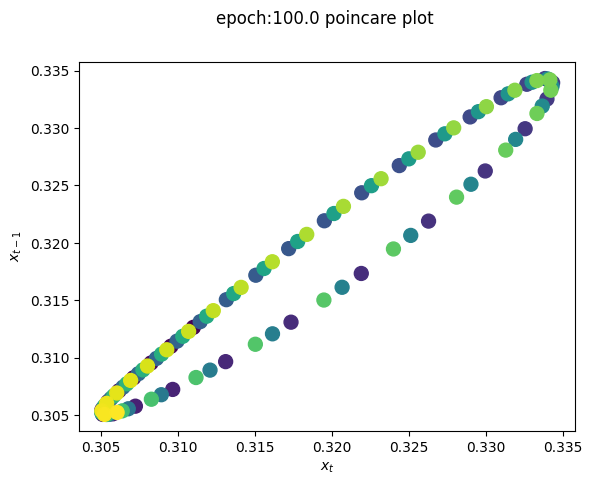

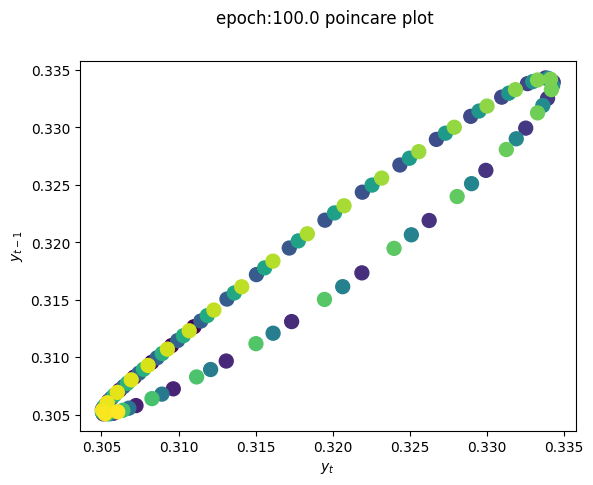

Epoch:  120
----------------------
[0.1474318128089733, 0.1474318128089734, 0.14743181280897338, 0.1474318128089734, 0.1474318128089734, 0.14743181280897344, 0.1474318128089734, 0.1474318128089734, 0.1474318128089734, 0.1474318128089734, 0.14743181280897347, 0.14743181280897344, 0.1474318128089734, 0.1474318128089734, 0.1474318128089734, 0.14743181280897336, 0.14743181280897336, 0.14743181280897336, 0.14743181280897338, 0.1474318128089734, 0.1474318128089734, 0.14743181280897347, 0.14743181280897347, 0.14743181280897347, 0.14743181280897344, 0.14743181280897344, 0.1474318128089734, 0.14743181280897347, 0.1474318128089734, 0.14743181280897344, 0.1474318128089734, 0.1474318128089734, 0.1474318128089734, 0.14743181280897338, 0.14743181280897338, 0.1474318128089734, 0.14743181280897338, 0.1474318128089734, 0.1474318128089734, 0.14743181280897338, 0.1474318128089734, 0.1474318128089734, 0.1474318128089734, 0.14743181280897338, 0.1474318128089734, 0.1474318128089734, 0.1474318128089734, 0.14

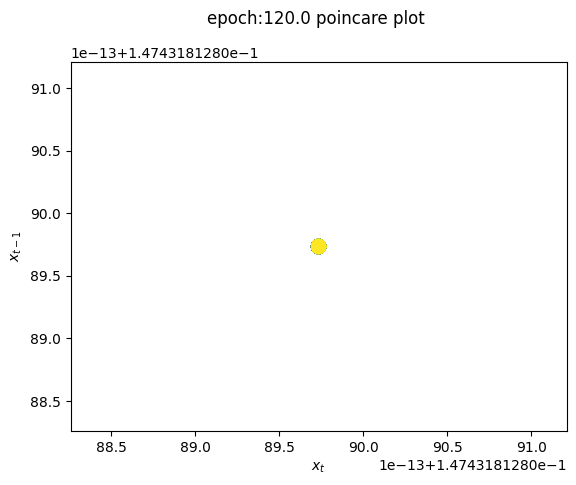

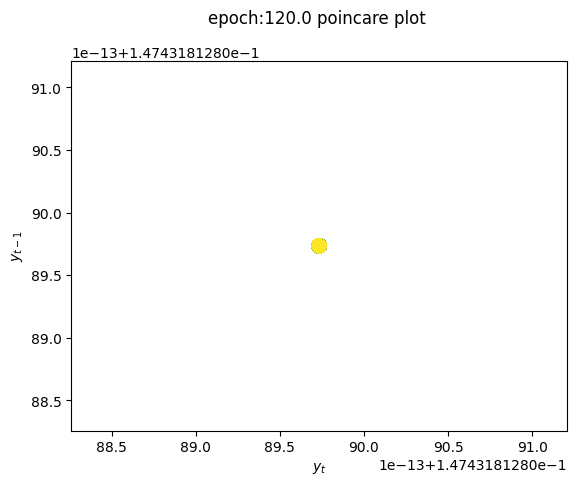

Epoch:  180
----------------------
[0.39782587150377524, 0.39783701331667354, 0.3978463412826112, 0.39785317886658444, 0.3978569197507202, 0.3978571017916303, 0.3978534882360464, 0.39784614105209015, 0.3978354683358608, 0.3978222291031126, 0.39780748537468, 0.39779250253889076, 0.3977786116601134, 0.39776705750883573, 0.39775885983807546, 0.3977547113150569, 0.397754925128981, 0.39775943257280716, 0.39776782024567026, 0.3977793909633717, 0.39779323274264283, 0.3978082850664931, 0.39782339866807187, 0.39783739176197663, 0.39784910993875994, 0.3978574974864013, 0.3978616842321409, 0.39786108463712744, 0.3978554965510856, 0.3978451786872021, 0.39783088216845397, 0.397813815560451, 0.3977955355069645, 0.3977777736588405, 0.39776222886618134, 0.3977503643766092, 0.39774324836389724, 0.39774146295084867, 0.397745087399692, 0.3977537428267539, 0.3977666746347674, 0.3977828471064313, 0.3978010308497715, 0.39781987447541967, 0.3978379630721371, 0.39785387448820636, 0.3978662479342057, 0.3978738

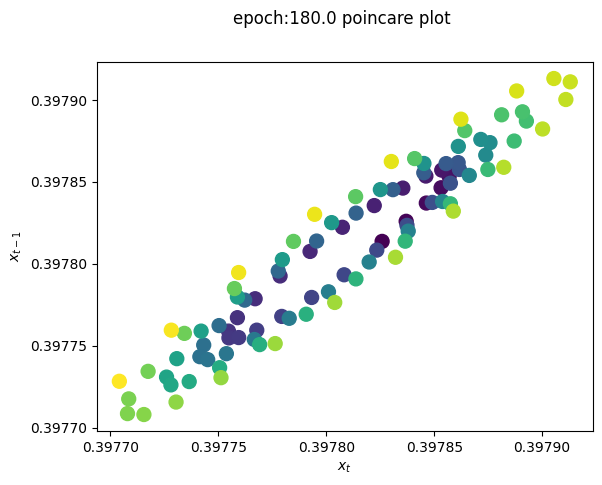

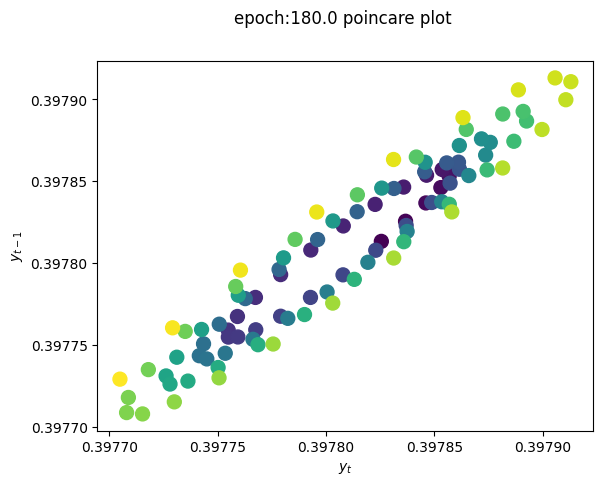

Epoch:  185
----------------------
[0.39168906563997813, 0.391689065639978, 0.3916890656399781, 0.3916890656399781, 0.3916890656399781, 0.3916890656399781, 0.391689065639978, 0.391689065639978, 0.3916890656399781, 0.391689065639978, 0.391689065639978, 0.391689065639978, 0.3916890656399781, 0.391689065639978, 0.391689065639978, 0.3916890656399781, 0.391689065639978, 0.391689065639978, 0.3916890656399781, 0.3916890656399781, 0.391689065639978, 0.391689065639978, 0.3916890656399781, 0.391689065639978, 0.3916890656399781, 0.3916890656399781, 0.391689065639978, 0.391689065639978, 0.391689065639978, 0.391689065639978, 0.391689065639978, 0.391689065639978, 0.391689065639978, 0.391689065639978, 0.391689065639978, 0.391689065639978, 0.391689065639978, 0.391689065639978, 0.391689065639978, 0.391689065639978, 0.3916890656399781, 0.3916890656399781, 0.391689065639978, 0.391689065639978, 0.391689065639978, 0.3916890656399781, 0.391689065639978, 0.391689065639978, 0.391689065639978, 0.39168906563997

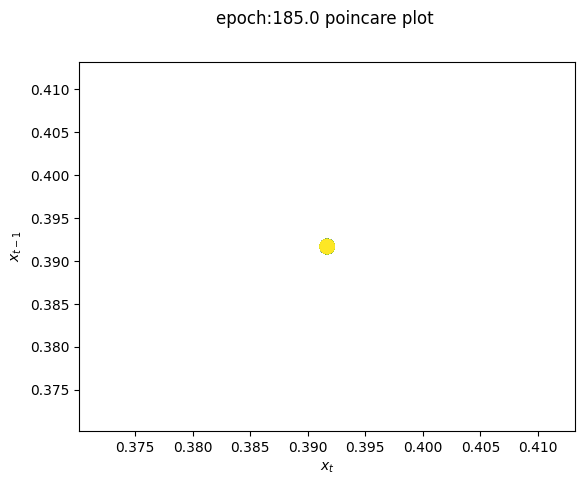

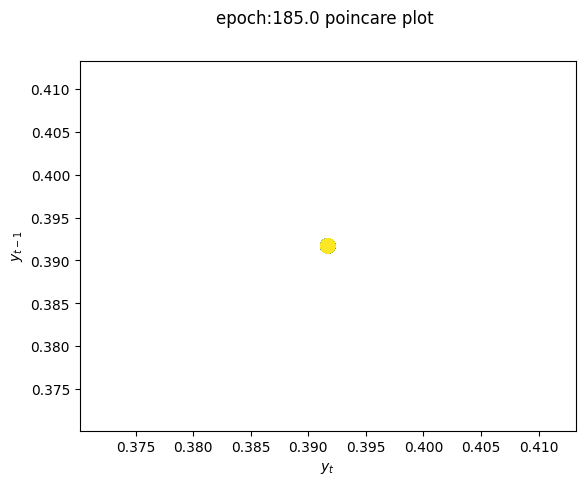

Epoch:  200
----------------------
[0.46507508113322715, 0.46271024204600897, 0.4593229834802698, 0.4567201202953153, 0.45607934778748466, 0.45691491105693716, 0.45878819549725064, 0.461000398248946, 0.46312474701001977, 0.46496374146772806, 0.46570209350143055, 0.46458141682589293, 0.46183046026859964, 0.4584369900593195, 0.4563613910952897, 0.45618108163659543, 0.45735020832004086, 0.4593931069465378, 0.46159574062463743, 0.4636790215366018, 0.46532241434407845, 0.46558601454344, 0.46396253888931716, 0.4608902862921329, 0.4576623655686391, 0.4561506443013082, 0.4563821852469825, 0.45785414253861223, 0.46000511085969914, 0.46218251734875665, 0.4642061198156686, 0.46557425818838916, 0.46532100294318, 0.46323179288563804, 0.45992880329501645, 0.4570359917407819, 0.45606990431198957, 0.45667780537729635, 0.45841079053575834, 0.4606134765158723, 0.4627598225839656, 0.46468808295757297, 0.465697821131178, 0.4649137320064395, 0.4624045279067387, 0.45899642960209486, 0.45657381343887277, 0.4

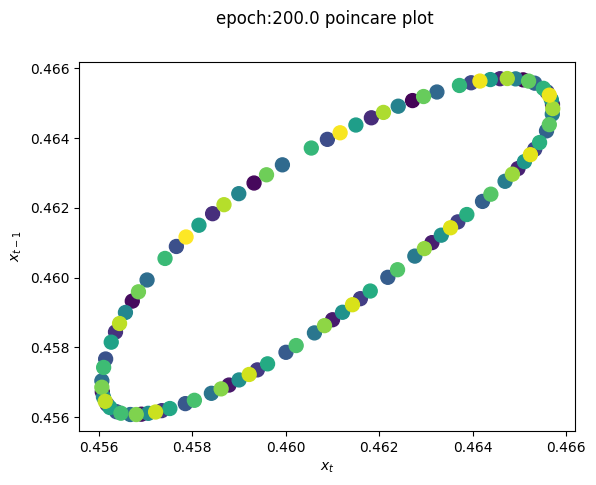

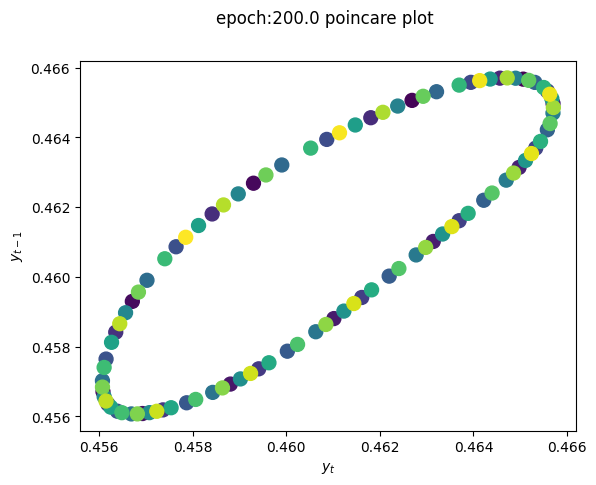

Epoch:  215
----------------------
[0.5024408043941758, 0.505466405698085, 0.5047708479152695, 0.5030228259675429, 0.5018098576899419, 0.5011563657944563, 0.5008744912998832, 0.5008467854636441, 0.5009581550809454, 0.5011230686602873, 0.5013055980801403, 0.5015056771173195, 0.5017427976114959, 0.502043634633076, 0.5024274460106583, 0.5028786702848153, 0.5033241980975898, 0.503664058521706, 0.503837625154706, 0.5038447319368091, 0.5037185828258255, 0.5034997533864964, 0.503226685545295, 0.5029327739575192, 0.5026444645797454, 0.5023832219174154, 0.5021688044164615, 0.5020179088953624, 0.5019408596427909, 0.5019417451318561, 0.5020217373219775, 0.5021815161404152, 0.5024189718539246, 0.502720304098978, 0.5030487561513757, 0.5033459064952382, 0.5035548619812739, 0.503645837025175, 0.5036203158068371, 0.5034988606242218, 0.5033091469998522, 0.5030796325447028, 0.5028363886293249, 0.5026018330595463, 0.5023953939079286, 0.5022339544823412, 0.5021306431535493, 0.5020937720583201, 0.502127540

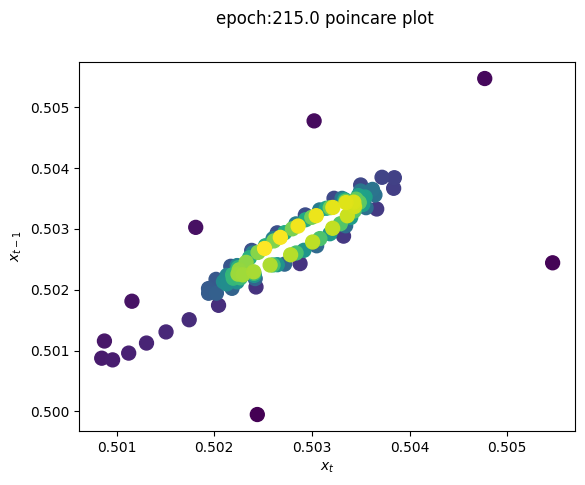

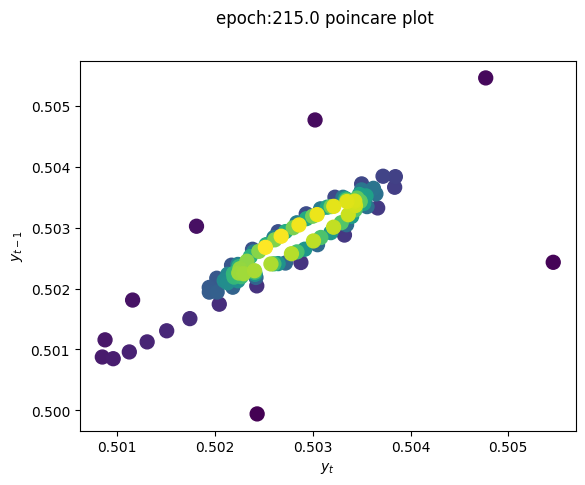

Epoch:  235
----------------------
[0.5629730548901039, 0.5655880909848306, 0.5703685069055093, 0.5742678897437705, 0.575134209683209, 0.5724758804710722, 0.5688937194934209, 0.5681187585433968, 0.5662379174033128, 0.5643988139170284, 0.562917375112068, 0.5657023603704863, 0.5704492054153022, 0.5743437345312421, 0.5751036758035682, 0.5723882822722189, 0.5688520330023736, 0.5680835050109463, 0.5661900747647741, 0.5643624142817325, 0.5628605091456091, 0.5658201718050218, 0.5705324373392712, 0.5744207462751543, 0.5750707979598133, 0.5722968910480811, 0.5688122553325277, 0.5680456456572041, 0.5661401785408214, 0.5643252879046169, 0.5628039237951172, 0.5659405207193586, 0.5706176057989406, 0.5744979209542185, 0.5750357513550092, 0.572202600357746, 0.5687750801611166, 0.5680055420851877, 0.5660887801272048, 0.5642879981770492, 0.5627493440719642, 0.5660622752748687, 0.5707040184443963, 0.5745741558063601, 0.5749988052710047, 0.5721064874555803, 0.568741083361797, 0.5679637018732305, 0.566036

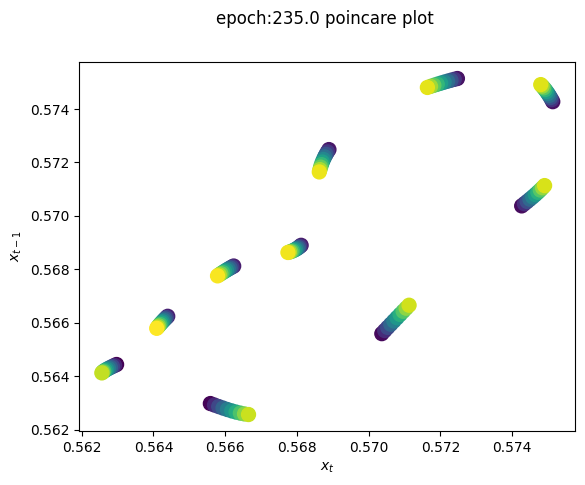

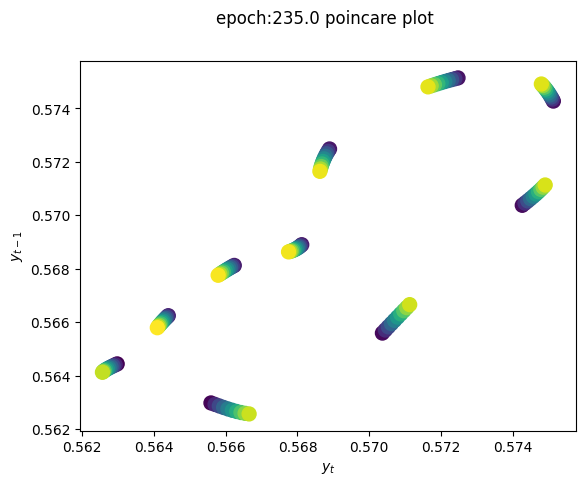

Epoch:  250
----------------------
[0.4215168968049522, 0.42152869486173167, 0.42221814086303816, 0.42391037877463805, 0.4268859519271896, 0.4302119655420447, 0.4302989125756381, 0.42494026524839057, 0.4215171145693199, 0.4215285608406477, 0.42221778589408987, 0.4239096431126013, 0.42688485711401386, 0.4302112112939334, 0.430299878704333, 0.4249422302974159, 0.4215173358403106, 0.42152842492034737, 0.4222174258740467, 0.4239088968914135, 0.4268837464369672, 0.4302104457332159, 0.4303008582163408, 0.4249442242849487, 0.4215175606758292, 0.42152828706875506, 0.42221706072590415, 0.423908139952261, 0.42688261965651514, 0.43020966868201277, 0.43030185130290033, 0.4249462476657521, 0.4215177891424121, 0.4215281472595292, 0.42221669037566534, 0.42390737213554963, 0.4268814765271998, 0.4302088799534103, 0.4303028581529229, 0.42494830090247365, 0.4215180213066076, 0.4215280054638211, 0.4222163147462907, 0.4239065932776399, 0.426880316798671, 0.4302080793570182, 0.43030387895809363, 0.424950384

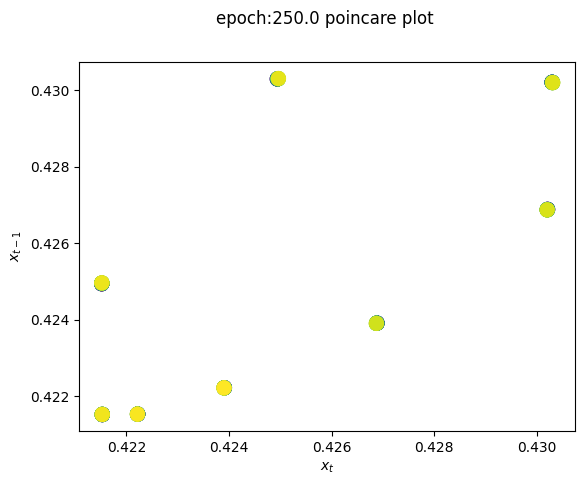

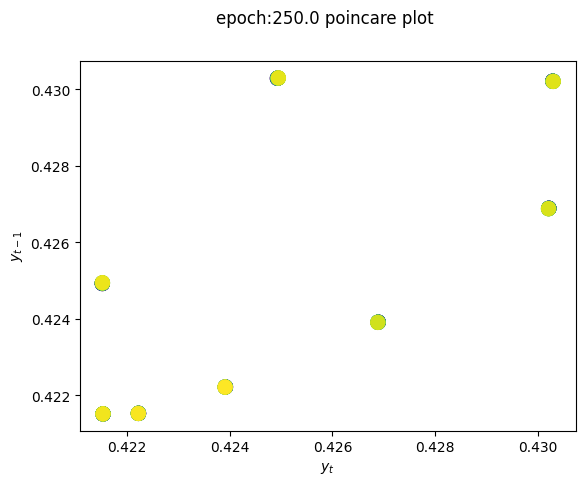

Epoch:  275
----------------------
[0.43839811140785473, 0.44579087187851624, 0.45072596424305383, 0.4517839485787388, 0.4520366952120768, 0.4520762840556956, 0.4524237541663186, 0.4534467197116194, 0.4550814600585143, 0.4565197666295801, 0.4572799657185569, 0.45809812523843324, 0.4596799697171411, 0.4595603709900313, 0.45554181384810394, 0.4474437495589563, 0.440592008638665, 0.4401219748419703, 0.438712750190568, 0.43621428447646404, 0.4348952151655093, 0.4356246119196287, 0.4383981054476386, 0.44579086366776016, 0.4507259621848863, 0.451783947647979, 0.4520366945638382, 0.45207628390440896, 0.4524237544003551, 0.4534467200209148, 0.455081460251464, 0.4565197666826171, 0.45727996577970453, 0.4580981254617331, 0.45967997008013917, 0.45956037030226654, 0.455541813157948, 0.4474437476636149, 0.44059200826248074, 0.4401219748208834, 0.43871274978958297, 0.43621428410756957, 0.4348952151447896, 0.43562461210276987, 0.43839810631195714, 0.4457908648584414, 0.45072596248335095, 0.4517839477

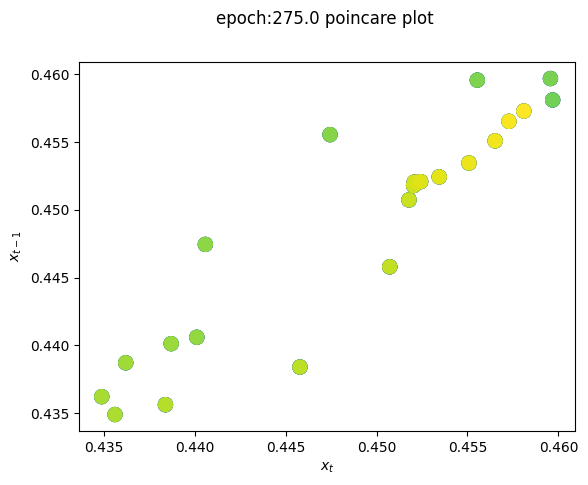

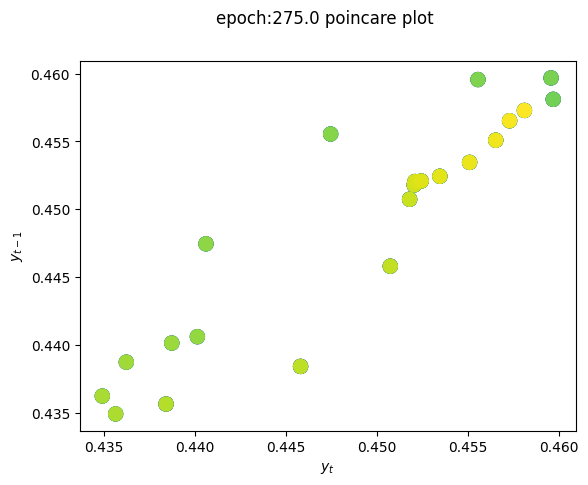

Epoch:  315
----------------------
[0.22412587522247124, 0.22644759898134598, 0.23418155121306858, 0.23370159298485765, 0.2349320237458741, 0.24134422231774355, 0.24018782808393804, 0.23800149437182241, 0.24004286698395172, 0.2322908249604768, 0.2272090547084179, 0.22886671090721694, 0.22315463147399756, 0.22497679062215334, 0.22894811202542908, 0.23135502763991717, 0.23972869253213966, 0.25002199269548464, 0.260218555914429, 0.2617408943852328, 0.24644745610988705, 0.2148778602268645, 0.19266447708413023, 0.20377750540891637, 0.21408235727057062, 0.2185552440270462, 0.22032782040536986, 0.22251892819406674, 0.2287921362088655, 0.23735819733280714, 0.24128223974485266, 0.23910722541408408, 0.23869875631165968, 0.24305442052570353, 0.24373012053034135, 0.25214377574077673, 0.26116081435819904, 0.260879786461827, 0.24830517227586144, 0.2326496833088466, 0.21231936216685662, 0.2110754377194891, 0.22197898061661456, 0.23006172237994496, 0.22626010465658628, 0.22308872951154302, 0.230445132

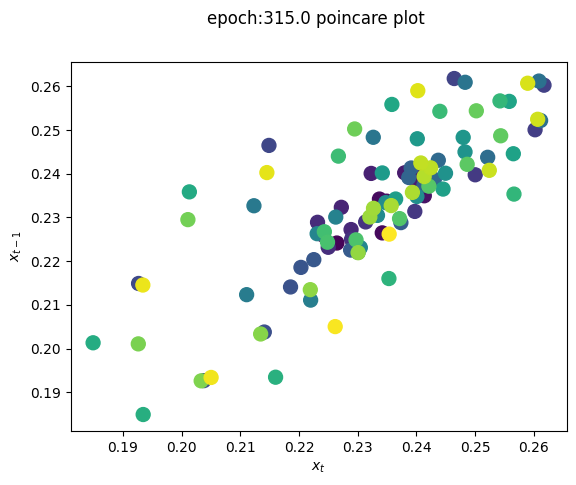

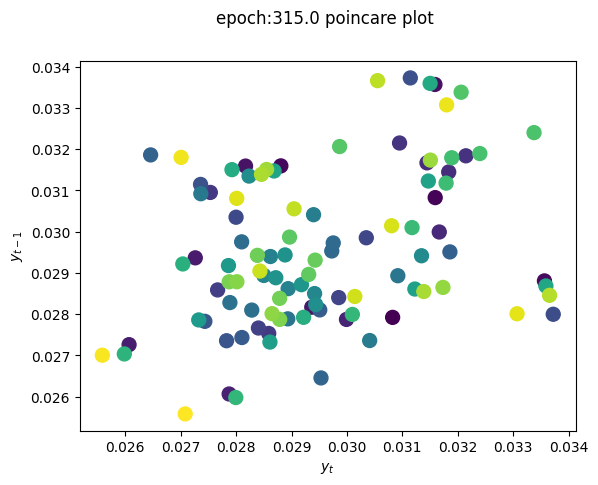

Epoch:  370
----------------------
[0.13696539945546296, 0.13799643909820392, 0.1400316795857411, 0.14058057091719695, 0.13984863091541658, 0.13871082697145212, 0.1376438455178582, 0.13638103779071595, 0.13616917469514528, 0.13852472909035835, 0.14054964031756076, 0.13916300245189267, 0.13821639915278147, 0.13762897389519585, 0.13709133868384762, 0.1374204881841924, 0.1395325619634482, 0.14062200081521894, 0.1401343784535837, 0.13904894707357318, 0.1379496330837988, 0.13675166067781325, 0.13595436680350215, 0.13762584098746325, 0.14036665231248058, 0.13964541489304913, 0.13843745306788302, 0.1378029281877101, 0.13726940290984035, 0.13706794709298856, 0.13892765736951004, 0.14049918415221796, 0.14035203388647308, 0.1393674333300958, 0.13824000389772112, 0.13713768886960284, 0.13600814521742954, 0.1369312004684076, 0.1398414126016172, 0.14015041398430875, 0.13867284694798707, 0.13795143019611905, 0.13740328311112562, 0.13695664406660343, 0.13833809743874148, 0.1402408952898078, 0.1405132

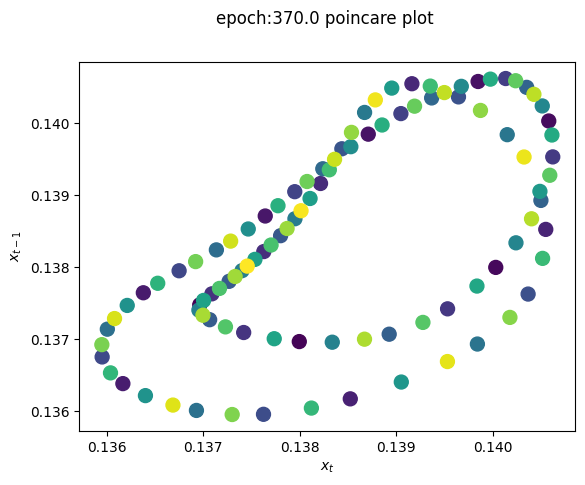

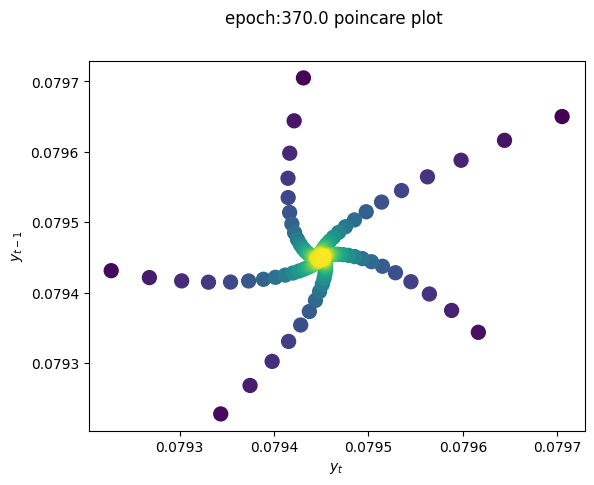

Epoch:  405
----------------------
[0.5786309558605128, 0.5773839265511169, 0.578080478901682, 0.5793134351177742, 0.5797858891227172, 0.5795682792058069, 0.5782748393011851, 0.5773390456142378, 0.5784122487304634, 0.5794798813857467, 0.5798042087487411, 0.5793750906463925, 0.5779372230764888, 0.5774276783072623, 0.5787256728715059, 0.5796097194654589, 0.5797885378009333, 0.5791101554146164, 0.5776497480754198, 0.5776393897685861, 0.5789998570760096, 0.5797052451513903, 0.5797341983387561, 0.5787861573212333, 0.5774419525639604, 0.5779352637083711, 0.5792275196430309, 0.5797685116337363, 0.5796323287481623, 0.5784317608990793, 0.5773419831020717, 0.5782660687297678, 0.5794115616710737, 0.5798006521441513, 0.5794694890281067, 0.5780813831045034, 0.5773715299655746, 0.5785915289325936, 0.5795572113706159, 0.5798001944061105, 0.579235374148695, 0.5777678688538579, 0.5775327424567976, 0.5788849624494405, 0.5796675706344964, 0.5797634839797503, 0.5789342921170844, 0.5775213904289129, 0.5777

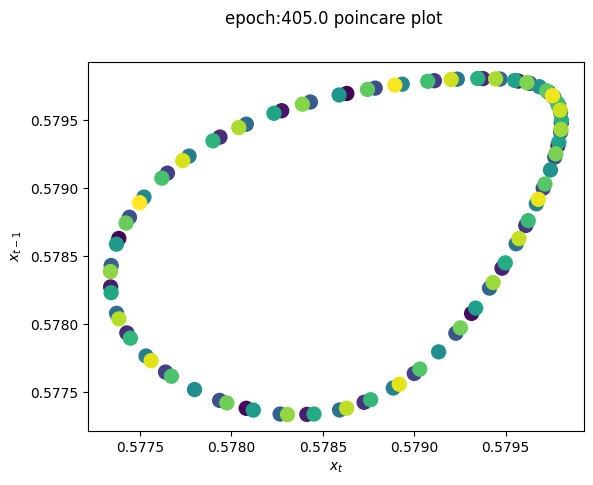

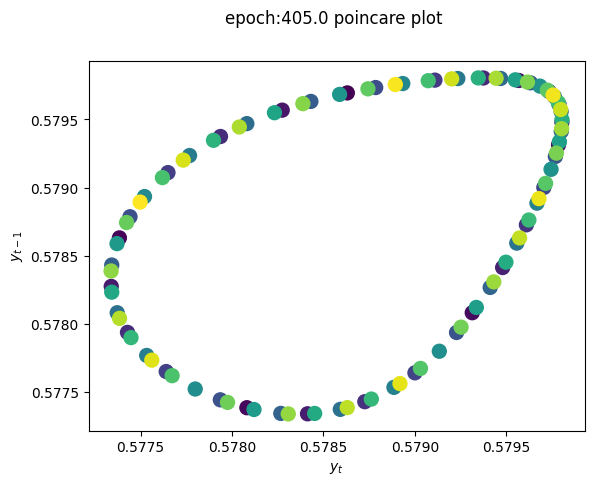

Epoch:  410
----------------------
[0.5288185015586659, 0.520720056030842, 0.5228279872625604, 0.5288257351001614, 0.5207154666320278, 0.5228239849474702, 0.5288238395770964, 0.5207169898266569, 0.522825112611296, 0.5288240889599801, 0.5207199039887926, 0.5228275846855953, 0.528827282634691, 0.5207208444372234, 0.5228284347960523, 0.5288298696185021, 0.5207206731579769, 0.5228282992244061, 0.5288308829182027, 0.5207207794270206, 0.5228283715774333, 0.5288313989844854, 0.5207212256374633, 0.5228287404091198, 0.5288320742938909, 0.5207215774282675, 0.522829040530393, 0.5288327554824594, 0.5207217289841346, 0.5228291710602833, 0.5288332285793911, 0.5207218163657148, 0.5228292436921229, 0.5288335298639226, 0.5207219183747366, 0.5228293280927819, 0.5288337672504578, 0.5207220160238193, 0.5228294100312112, 0.5288339748666538, 0.5207220847416724, 0.5228294681175851, 0.5288341405246975, 0.5207221302450196, 0.5228295064067414, 0.5288342624227125, 0.520722166162077, 0.5228295364265363, 0.5288343

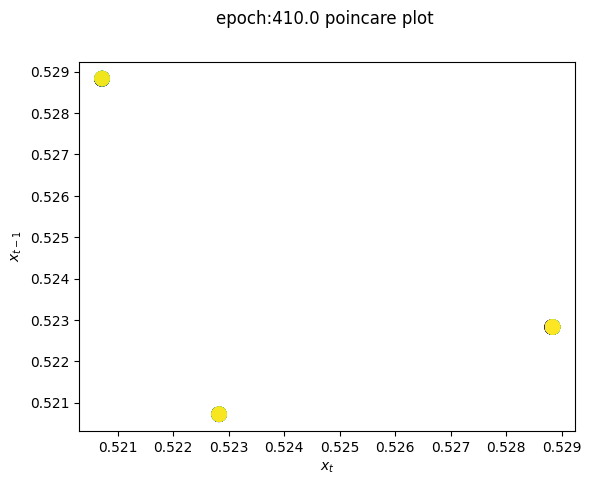

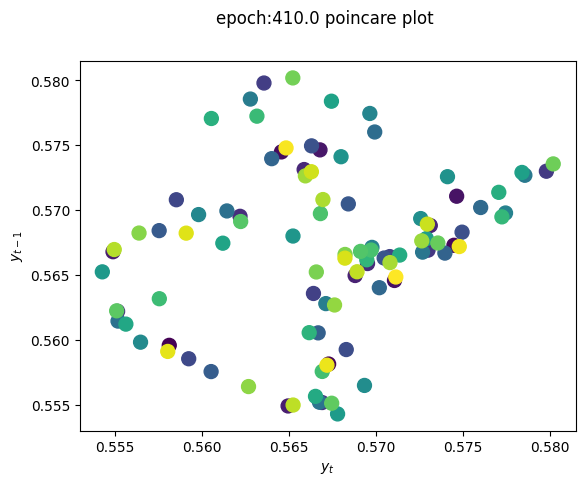

Epoch:  435
----------------------
[0.1972036112066834, 0.19810170874562963, 0.19875831868186528, 0.19930065975520872, 0.20011917773567023, 0.20029253807848535, 0.19922096159565333, 0.19766875607624632, 0.19718152858554835, 0.19803859489781697, 0.19873307811273502, 0.19925564690711356, 0.20007611813424092, 0.20031697932808568, 0.19931592324022077, 0.19774468835759307, 0.19716546624004705, 0.19797396680202578, 0.1987076936232959, 0.19921276008624403, 0.2000310513905286, 0.20033635107376144, 0.1994077356318214, 0.19782434862914106, 0.19715557368667497, 0.1979088457356355, 0.1986818642245129, 0.1991721353084244, 0.19998451387167065, 0.2003507209634256, 0.19949570524153518, 0.19790702966780235, 0.19715186450938335, 0.1978440943671487, 0.1986553577285135, 0.19913393031359472, 0.19993710864320483, 0.20036027362205433, 0.19957922516928936, 0.19799187689461967, 0.1971541085527293, 0.19778050176305437, 0.1986278696832346, 0.1990980503092922, 0.19988924645013736, 0.20036527997838394, 0.199658060

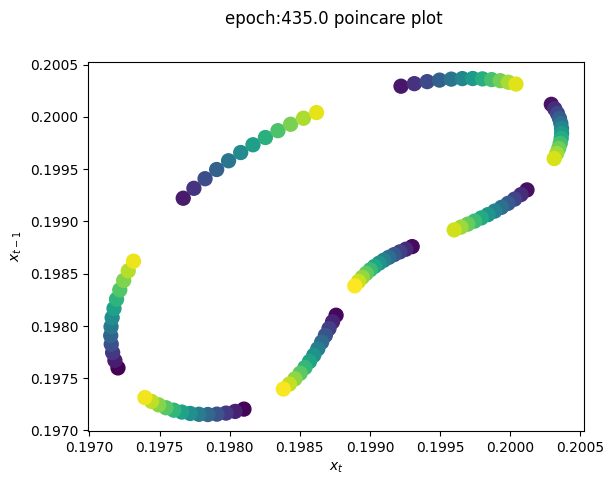

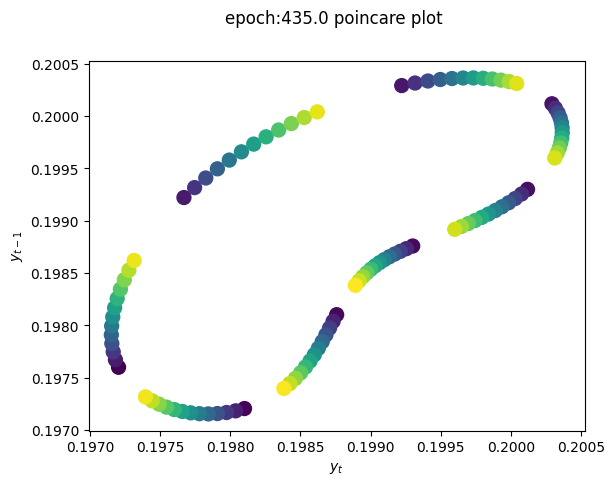

Epoch:  445
----------------------
[0.5018818698396739, 0.4962589742933326, 0.49891636487023644, 0.5054521842738687, 0.5036931659607385, 0.4976017548563783, 0.49640161604202027, 0.5034330646831355, 0.5076051667765311, 0.5015380798684295, 0.4961511291221192, 0.49947296836321664, 0.5057342416692306, 0.5030693045319079, 0.4971981321913853, 0.4967817330080488, 0.5038715854245801, 0.5072067279815525, 0.5009559124802896, 0.4960224659472165, 0.5001897953367842, 0.5061444754844585, 0.5025223167790446, 0.4968494312627959, 0.4972732878067637, 0.5043258059215017, 0.5064555416291693, 0.5000602382551189, 0.4959063693498354, 0.5011378033772356, 0.5067799230165195, 0.5021559785710438, 0.496555106055652, 0.49785040638209266, 0.5047931218641336, 0.5054160584690465, 0.4989951373161256, 0.49591659943500277, 0.5021522664282384, 0.5074445895799912, 0.502037427359438, 0.4963692905323238, 0.4983953300471488, 0.5051723711366668, 0.5044610648180252, 0.4981625363908939, 0.496099812634576, 0.5029059603894819, 0.

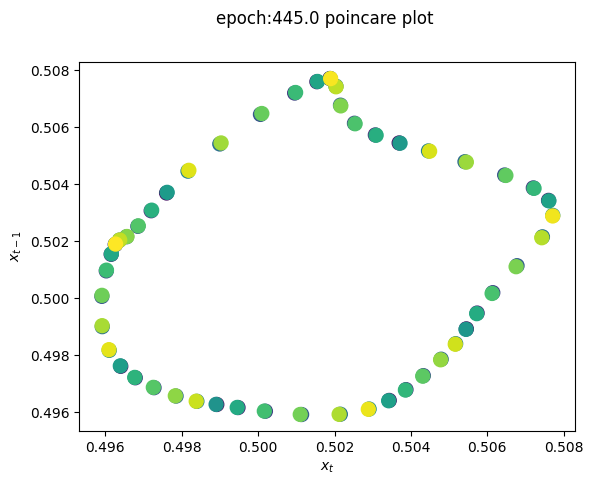

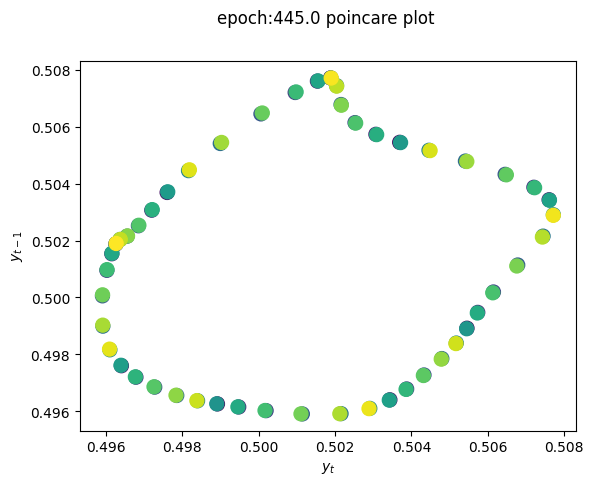

Epoch:  455
----------------------
[0.6035496611615858, 0.6001989013894654, 0.6017964182641717, 0.6033749295847735, 0.6043946543497684, 0.6009986636132427, 0.6021873479798894, 0.6039291898584184, 0.6045463321946286, 0.6010804244805804, 0.6014490654302508, 0.6035476987001926, 0.6047744465127397, 0.6023307216416482, 0.6006068710073782, 0.6027333926088574, 0.6037887457461922, 0.6037585494909261, 0.601035151165622, 0.6025663328441264, 0.6041485932589195, 0.6034622520798644, 0.5999191548792906, 0.6010502094827888, 0.6028895165953185, 0.6044403429056983, 0.6009624043140186, 0.6012844443773548, 0.6037780627062801, 0.6049804318134371, 0.6025832193735878, 0.6002167226639318, 0.6021947535512148, 0.6034365313695562, 0.6038799135602689, 0.600838039017601, 0.602360135156019, 0.6041035851185624, 0.6038425976970966, 0.5999124087042508, 0.6008963923238083, 0.60285560305353, 0.6044083968472362, 0.601052300164087, 0.6010006567460774, 0.6035956577354424, 0.6047349590032924, 0.6030439499660334, 0.59984677

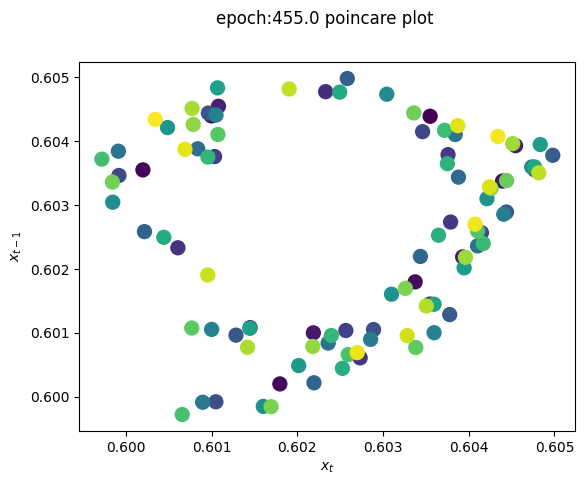

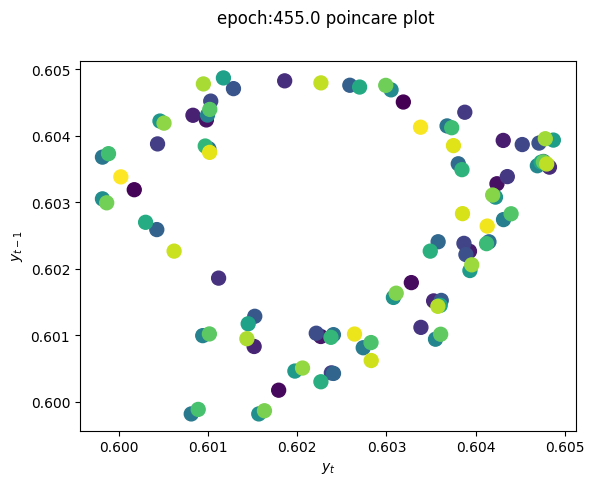

Epoch:  475
----------------------
[0.6020176190821718, 0.6055316878930851, 0.6039547429346331, 0.6022712105729119, 0.6047781083269802, 0.6048453986330105, 0.6026010164345509, 0.5967259596927715, 0.593605024125391, 0.5942545356470258, 0.6027062064509167, 0.6017576207707898, 0.60393354706896, 0.5990116484319257, 0.5939553748340858, 0.6034171459591636, 0.604928049510717, 0.6032364007941352, 0.604444618356396, 0.6051220865906934, 0.6045455902244267, 0.6015780443266594, 0.5959058542121133, 0.592827283697427, 0.5956643037983835, 0.6027842645023057, 0.6020314185678025, 0.604343792455136, 0.5973535499880162, 0.5966094358638009, 0.6033149663149424, 0.603891889711579, 0.602675029469912, 0.6047449673240929, 0.6050876728082486, 0.6039511342117043, 0.5996769690724928, 0.5951772144214857, 0.5927903206556437, 0.5986885640239512, 0.6013667743766059, 0.6024417337268768, 0.6035009280670918, 0.595535617401918, 0.6015052717068019, 0.6053831050874929, 0.6039819942933197, 0.6022859854824978, 0.604780553760

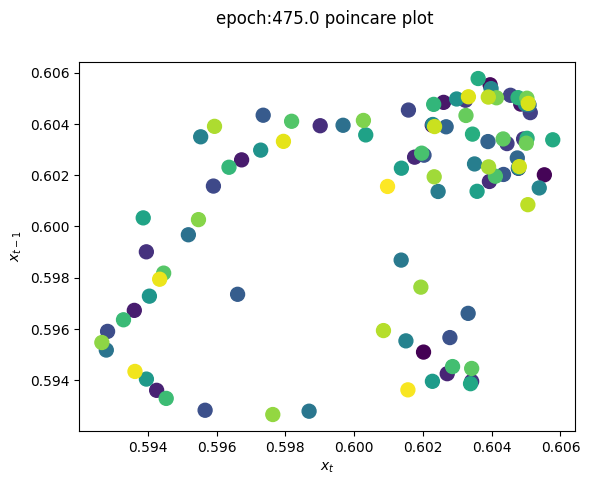

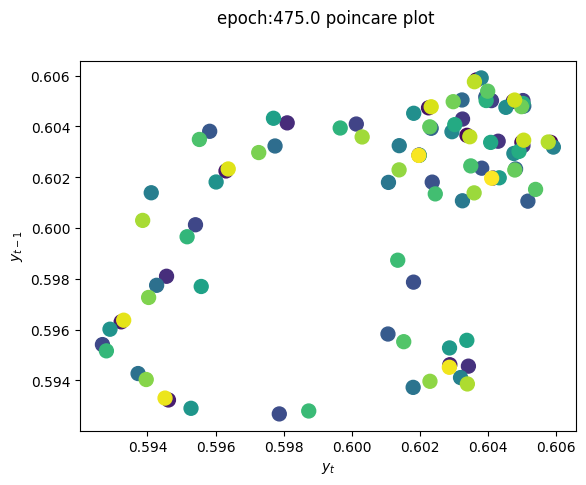

Epoch:  485
----------------------
[0.35055351141367247, 0.35059996236958696, 0.35081532010941957, 0.35139265864864255, 0.3523363729073265, 0.3532533653845922, 0.3561898180094454, 0.3587091442400513, 0.3612171894194185, 0.36147699207705636, 0.3608789889920929, 0.360351562945301, 0.3601868259962372, 0.3601195722377892, 0.3594878228087641, 0.3584773754708402, 0.3568294413319161, 0.35527690225918906, 0.3535675963565854, 0.3534123506329139, 0.35375975773719387, 0.3535711900353186, 0.35297306179274757, 0.352164128579605, 0.35137506579156913, 0.35086311612617893, 0.35064721643217917, 0.35059125782795614, 0.35058679723786185, 0.35059597272214715, 0.35060539745108443, 0.35060850856699677, 0.35060303721231023, 0.35058944150168214, 0.350570483294646, 0.35055424967545024, 0.35056557380143144, 0.35067718712178625, 0.3510546039647372, 0.3518447450421493, 0.35284047828334936, 0.3539420718300148, 0.3577043365162288, 0.3601500885154208, 0.3614218832717903, 0.3611274608691591, 0.36054318772088184, 0.36

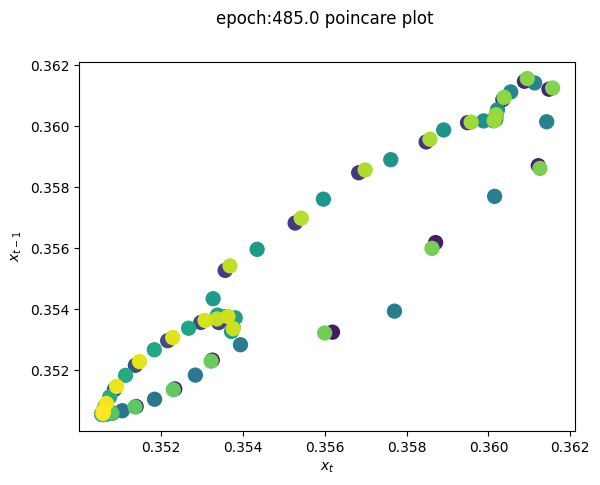

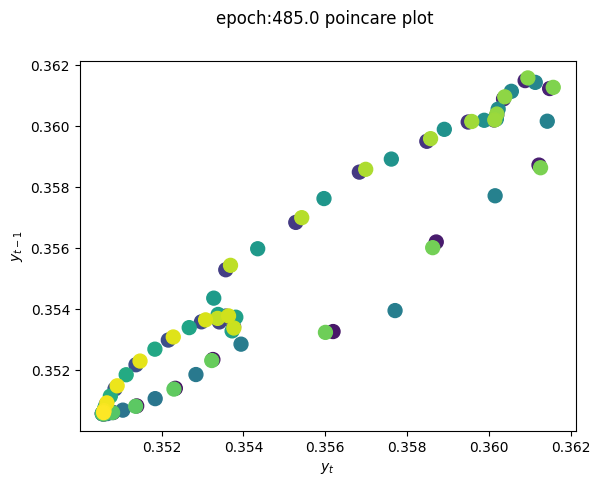

In [119]:
cycle_detection = BrentCycleDetection(1e-7)


for epoch in int_epoch:
    print("Epoch: ", epoch)
    print("----------------------")
    xt = np.loadtxt(run_date +"/" + "xt_" + str(epoch) + ".txt")
    xtminus = np.loadtxt(run_date +"/" + "xtminus_" + str(epoch) + ".txt")
    yt = np.loadtxt(run_date +"/" + "yt_" + str(epoch) + ".txt")
    ytminus = np.loadtxt(run_date +"/" + "ytminus_" + str(epoch) + ".txt")


    print(list(xt))
    print(len(xt))
    
    print("----------------------")
   
    print("Cycle detection for xt")
    print("----------------------")
    cycle_detection.compute_tolerance(xt)
    print(cycle_detection.get_tolerance())
    cycle_detection.detect_cycle(xt)
    cycle_detection.print_result()

    print("----------------------")
    print("Cycle detection for yt")
    print("----------------------")
    cycle_detection.compute_tolerance(yt)
    cycle_detection.detect_cycle(yt)
    cycle_detection.print_result()

    # print("----------------------")
    # print("Lyapunov exponent")
    # print("----------------------")
    # lyapunov = lyapunouv_exponent(xt, xtminus, yt, ytminus)
    # print(lyapunov)

    plt.scatter(xt,xtminus,c=colour,s=100)
    plt.xlabel("$x_t$")
    plt.ylabel("$x_{t-1}$")
    plt.title("epoch:{:.1f} poincare plot ".format(epoch),y=1.08)
    #plt.xscale("log")
    #plt.yscale("log")
    plt.show()

    plt.scatter(yt,ytminus,c=colour,s=100)
    plt.xlabel("$y_t$")
    plt.ylabel("$y_{t-1}$")
    plt.title("epoch:{:.1f} poincare plot ".format(epoch),y=1.08)
    #plt.xscale("log")
    #plt.yscale("log")
    plt.show()

    
    